### This notebook focuses on visualization of accident risk.

In [1]:
# Imports and helper functions
import json
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import operator
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab

%matplotlib inline

def plot_line(ax, ob, color):
    x, y = ob.xy
    ax.plot(x, y, color=color, linewidth=1, zorder=1)
    
def recurse(d, maximum, minimum, key):
    if type(d)==dict:
        for k,v in d.items():
            if (k==key):
                maximum, minimum = recurse(d[k], maximum, minimum, key)
    else:
        if (d>maximum):
            maximum=d
            return maximum, minimum
        if (d<minimum):
            minimum = d
            return maximum, minimum
    return maximum, minimum

In [4]:
# Load in the network
network = nx.read_gpickle('/home/louisf/Documents/Insight/massdriver/notebooks/graph_with_risk2.pickle')
net = nx.read_gpickle('/home/louisf/Documents/Insight/massdriver/data/filled_reduced_needs_risk.pickle')


In [8]:
for u,v in network.edges_iter():
    net[u][v]['acc_risk']=network[u][v]['acc_risk']

In [16]:
nx.write_gpickle(net, '/home/louisf/Documents/Insight/massdriver/data/filled_reduced.pickle')

In [13]:
minimum = 0

for u,v in net.edges_iter():
    if net[u][v]['acc_risk']<minimum:
        minimum = net[u][v]['acc_risk']


In [15]:
for u,v in net.edges_iter():
    net[u][v]['acc_risk']=net[u][v]['acc_risk']+minimum

In [ ]:
# Plot a map using the edges of the network to define line segments. Use 'acc_risk' to color the edges

In [3]:
lines = {}

it=0
for u, v in network.edges_iter():
    js = network[u][v]['Json']
    coords = json.loads(js)['coordinates']
    line = LineString(coords)
    lines[it] = {'line':line, 'rate':network[u][v]['acc_risk']}
    it+=1
    

In [18]:
maximum = 0
minimum = 0
all_rates = []

### HACK
maxval = np.std(all_rates)*10

for k,v in lines.items():
    rate = v['rate']
    if rate>maximum:
        maximum=rate
    if rate<minimum:
        minimum=rate
        
maxval = np.std(all_rates)*10
for k, v in lines.items():
    adj_rate = rate-minimum
    if adj_rate > maxval:
        adj_rate = maxval
    v['scaled_rate']=np.log10(rate-minimum+1)/np.log10(-minimum+maximum+1)
    v['adj_rate'] = adj_rate

KeyboardInterrupt: 

In [21]:

maxval = np.std(all_rates)*10
for k, v in lines.items():
    adj_rate = rate-minimum
    if adj_rate > maxval:
        adj_rate = maxval
    v['scaled_rate']=np.log10(rate-minimum+1)/np.log10(-minimum+maximum+1)
    v['adj_rate'] = adj_rate

In [26]:
# This generates the rate-coded map. This is slow!

colormap = plt.get_cmap('jet')
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1)
for k, v in lines.items():
    plot_line(ax, v['line'], colormap(log(v['adj_rate']))
fig.savefig('rescaled2.png', dpi=300, transparent=True)

SyntaxError: invalid syntax (<ipython-input-26-ca12f682bd23>, line 8)

In [ ]:
from osgeo import ogr, osr
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline

driver = ogr.GetDriverByName('ESRI Shapefile')
filepath = '/home/louisf/Documents/Insight/massdriver/data/raw/shapefile/RI_converted.shp'
dataset = driver.Open(filepath)

# from Layer
layer = dataset.GetLayer()
spatialRef = layer.GetSpatialRef()
# from Geometry
feature = layer.GetNextFeature()
geom = feature.GetGeometryRef()
spatialRef = geom.GetSpatialReference()

shp = ogr.Open(filepath)

In [ ]:
g = read_shp2(filepath, ['RoadSegmen', 'AssignedLe'], simplify=True)

In [ ]:
first = g.edges()[0]
g.edge[(-71.10891187098966, 42.474431813774984)][(-71.10750084168293, 42.47446692343721)]['AssignedLe']

In [ ]:
g2 = g
nx.convert_node_labels_to_integers(g, label_attribute="oldLabels")

In [ ]:
g.node

In [ ]:
it = 0
for n in g.nodes_iter():
    it+=1
    if (it%100 == 0):
        print(n)

In [ ]:
n = g.nodes()

p = nx.shortest_path(g, source=n[0], target = n[3])
len(p)

In [ ]:
import numpy as np
import scipy.spatial.distance as distance

In [ ]:
it=0
lat = 42.198
long = -70.9987
ar = np.empty((0, int(graph.net.number_of_nodes())))
it = 0 
for longitude, latitude in graph.net.nodes_iter():
    ar = np.append(ar, [[longitude, latitude]], axis=0)
    it+=1

In [ ]:
graph.net.number_of_nodes()

In [ ]:
from scipy.spatial.distance import cdist
a = np.array([[long, lat]])
others = np.asarray(graph.net.nodes())
def closest_point(pt, others):
    distances = cdist(pt, others)
    return distances.argmin()
closest_point(a, others)

In [ ]:
np.asarray(others)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

In [ ]:
import graphHandler as gh


graph = gh.NetworkGenerator()
filepath = '/home/louisf/Documents/Insight/massdriver/data/raw/shapefile/RI_converted.shp'
graph.loadGraph(filepath=filepath, fields=['RoadSegmen', 'AssignedLe'], simplify=True)

In [ ]:
lat1 = 42.198
long1 = -70.9987
start = gh.findClosestNode(graph.net, lat1, long1)
end = gh.findClosestNode(graph.net, lat1+.035, long1+.006)

In [ ]:
path = gh.getShortestPath(graph.net, tuple(start), tuple(end))

In [ ]:
import pickle


with open('graph.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
b=np.asarray(path)

In [ ]:
np.reshape(b.flatten(), (len(b),2))

In [ ]:
b

In [ ]:
lat1 = 42.198
long1 = -70.9987
lat2 = 42.298
long2 = -70.81
path = gh.pathingSolution(graph.net, lat1, long1, lat2, long2, 'AssignedLe')

In [ ]:
import numpy as np
a = np.array([[1, 1], [2,3]])

In [ ]:
import networkx as nx
import graphHandler as gh
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
graph = gh.NetworkGenerator()
filepath = '/home/louisf/Documents/Insight/massdriver/data/raw/shapefile/RI_converted.shp'
graph.loadGraph(filepath=filepath, fields=['RoadSegmen', 'AssignedLe'], simplify=True)

In [ ]:
pred_arr = np.load('data_with_prediction.npy')

In [ ]:
it=0
for u,v in graph.net.edges_iter():
    segnum = graph.net[u][v]['RoadSegmen']
    #rowid = pred_arr[:,48]==segnum
    try:
        rowid = np.nonzero(pred_arr[:,48]==segnum)[0][0]
        graph.net[u][v]['acc_risk'] = pred_arr[rowid,-1]
    except IndexError:
        graph.net[u][v]['acc_risk'] = 0
    
    it+=1

In [ ]:
nx.write_gpickle(graph.net, 'graph_with_risk2.pickle')

In [ ]:
segnum

In [ ]:
a = []
for u,v in graph.net.edges_iter():
    a.append(graph.net[u][v]['acc_risk'])

In [ ]:
np.nonzero(pred_arr[:,48]==segnum)[0][0]

In [74]:
minimum=0
maximum=0.1
for u,v in g.edges_iter():
    if g[u][v]['acc_risk']<minimum:
        minimum = g[u][v]['acc_risk']
    if g[u][v]['acc_risk']>maximum:
        maximum = g[u][v]['acc_risk']

In [79]:
np.std(riskvals)

0.21960491590037487

In [7]:
for u,v in g.edges_iter():
    g[u][v]['acc_risk']=g[u][v]['acc_risk']-minimum

In [9]:
nx.write_gpickle(g, '/home/louisf/Documents/Insight/massdriver/data/filled_reduced_zeroed.pickle')

In [5]:
g = nx.read_gpickle('/home/louisf/Documents/Insight/massdriver/data/filled_reduced_zeroed.pickle')

In [2]:
g = nx.read_gpickle('/home/louisf/Documents/Insight/massdriver/data/filled_reduced_zeroed.pickle')

In [6]:
latcent = 42.364506
longcent = -71.055#-71.038887
width = .06
newgraph = nx.Graph()
riskvals = []
graphrates = []
for u,v in g.edges_iter():
    if (u[0]<longcent+width and u[0]>longcent-width and u[1]<latcent+width and u[1]>latcent-width):
        newgraph.add_edge(u,v)
        r = g[u][v]['acc_risk']
        if r<6*np.std(riskvals):
            newgraph[u][v]['acc_risk']=g[u][v]['acc_risk']
            graphrates.append(g[u][v]['acc_risk'])
        else:
            newgraph[u][v]['acc_risk']=np.mean(riskvals)
            graphrates.append(np.mean(riskvals))
        riskvals.append(g[u][v]['acc_risk'])
    #x.append(u[0])
    #y.append(u[1])

/home/louisf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/louisf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [7]:
lines = {}

it=0
for u, v in newgraph.edges_iter():
    coords = [u,v]
    line = LineString(coords)
    lines[it] = {'line':line, 'rate':newgraph[u][v]['acc_risk']}
    it+=1

{0: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ece10>,
  'rate': 0.042676537315018193},
 1: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593eceb8>,
  'rate': 0.20590374940169603},
 2: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ecb38>,
  'rate': 0.10350232259613157},
 3: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ecb70>,
  'rate': 0.32517699342882228},
 4: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ec8d0>,
  'rate': 0.17878533040537936},
 5: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ecdd8>,
  'rate': 0.11993774742237884},
 6: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ecba8>,
  'rate': 0.088153251044528369},
 7: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ecbe0>,
  'rate': 0.067987743823422875},
 8: {'line': <shapely.geometry.linestring.LineString at 0x7ff3593ecc18>,
  'rate': 0.20263394973657739},
 9: {'line': <shapely.geometry.linestring.LineString

(array([ 6082.,  7249.,  2261.,   954.,   548.,   355.,   213.,   122.,
          106.,    78.]),
 array([  5.82262169e-04,   1.32133394e-01,   2.63684526e-01,
          3.95235657e-01,   5.26786789e-01,   6.58337921e-01,
          7.89889053e-01,   9.21440185e-01,   1.05299132e+00,
          1.18454245e+00,   1.31609358e+00]),
 <a list of 10 Patch objects>)

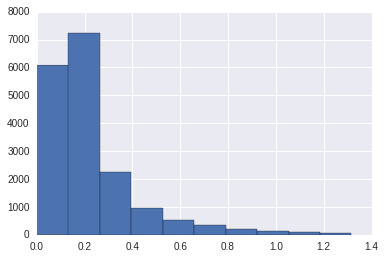

In [115]:
plt.hist(graphrates)

/home/louisf/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


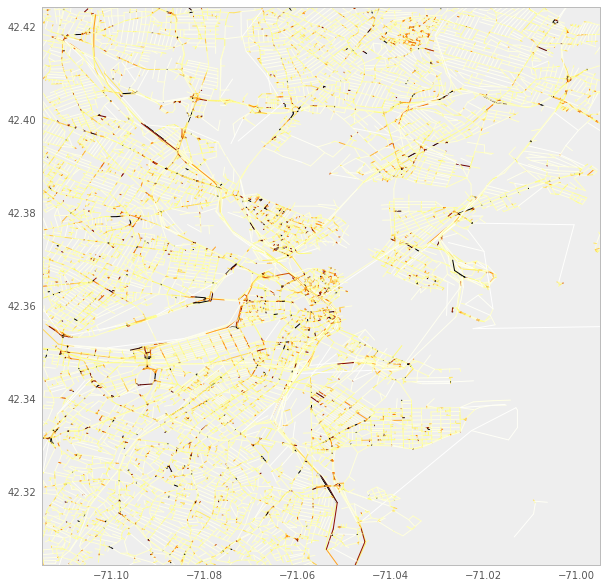

In [11]:
import matplotlib 
pd.options.display.mpl_style = 'default'
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

colormap = plt.get_cmap('afmhot_r')
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
for k, v in lines.items():
    plot_line(ax, v['line'], colormap(v['rate']))
plt.ylim(latcent-width, latcent+width)
plt.xlim(longcent-width, longcent+width)
fig.savefig('scaledrate3.png', dpi=250, transparent=True)


In [126]:
colormap